## Mounting to the project directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/2024-ML-AI-Projects/image-classification-project

/content/drive/MyDrive/2024-ML-AI-Projects/image-classification-project


In [3]:
!pwd

/content/drive/MyDrive/2024-ML-AI-Projects/image-classification-project


## Importing Necessary Libraries

In [17]:
from src import CIFAR10Preprocessor, CIFAR10DataIngestionPipeline
from utils import DATA_PATH, BATCH_SIZE, NUM_WORKERS, LEARNING_RATE, MOMENTUM, DEVICE, EPOCHS, MODEL_PATH
from utils import imshow, accuracy_fn, print_train_time

from src import Net, Trainer, ModelSaveLoad

import numpy as np
import torch

import matplotlib.pyplot as plt

## Data Ingestion and Preprocessing

In [5]:
preprocessor = CIFAR10Preprocessor()
pipeline = CIFAR10DataIngestionPipeline(root=DATA_PATH, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, preprocessor=preprocessor)
train_dataloader = pipeline.get_train_dataloader()
test_dataloader = pipeline.get_test_dataloader()

Files already downloaded and verified
Files already downloaded and verified


## Data Visualization

In [6]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([4, 3, 32, 32]), torch.Size([4]))

In [7]:
class_names = pipeline.get_class_names()

Image size: torch.Size([3, 32, 32])
Label: 2, label size: torch.Size([])


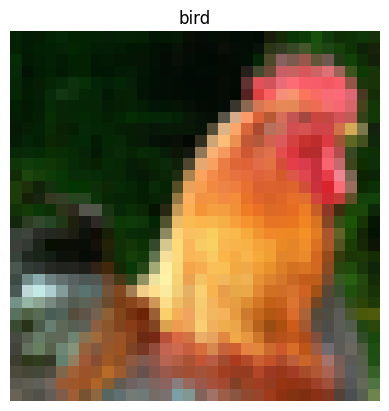

In [8]:
# Show a sample
torch.manual_seed(300)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
imshow(img, label)
plt.title(class_names[label])
plt.axis("off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

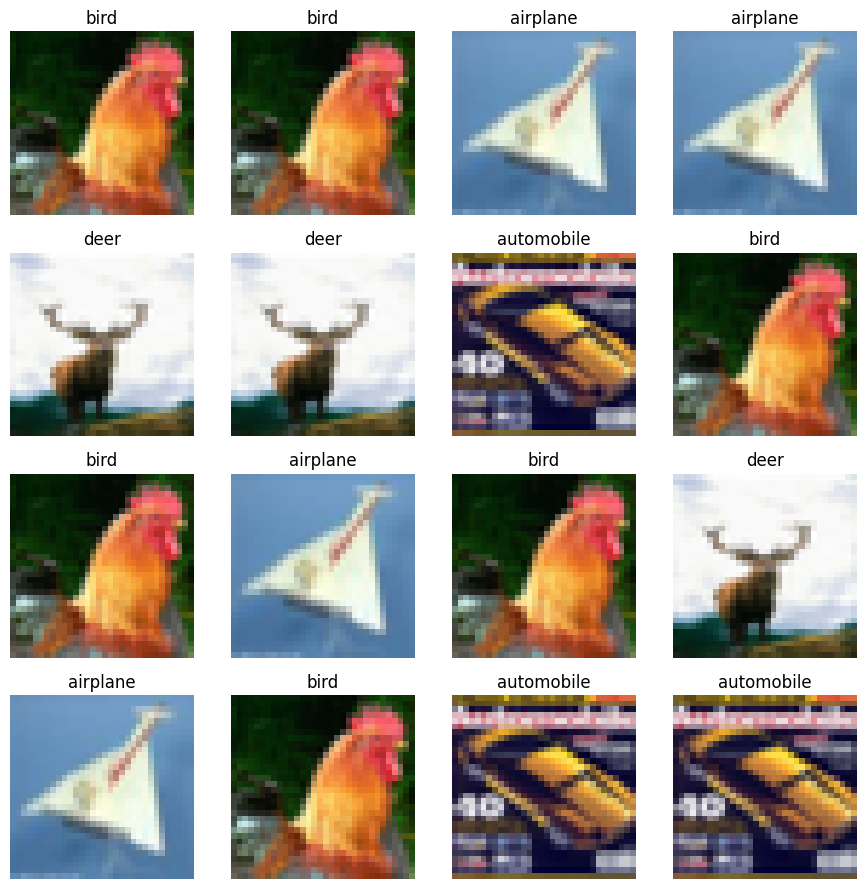

In [9]:
# Plot more images
torch.manual_seed(60)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
    img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
    fig.add_subplot(rows, cols, i)
    imshow(img, label)  # Convert tensor to numpy array and transpose dimensions
    plt.title(class_names[label])
    plt.axis(False)

plt.tight_layout()
plt.show()

## Model Instantiation

In [10]:
input_channels = train_features_batch.shape[1]
num_classes = len(class_names)

In [11]:
net = Net(input_channels=input_channels, num_classes=len(class_names))

## Model Training and Evaluation

In [12]:
training_pipeline = Trainer(model=net, accuracy_fn=accuracy_fn, device=DEVICE)

In [13]:
training_pipeline.setup(num_classes=num_classes, learning_rate=LEARNING_RATE, momentum=MOMENTUM)

In [14]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()
from tqdm.auto import tqdm


for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n---------")
    training_pipeline.train_step(data_loader=train_dataloader)
    training_pipeline.test_step(data_loader=test_dataloader)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu, device=DEVICE)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.46323 | Train accuracy: 47.60%
Test loss: 1.15873 | Test accuracy: 59.82%

Epoch: 1
---------
Train loss: 1.00876 | Train accuracy: 64.80%
Test loss: 0.93921 | Test accuracy: 66.89%

Epoch: 2
---------
Train loss: 0.83599 | Train accuracy: 70.80%
Test loss: 0.88548 | Test accuracy: 69.51%

Epoch: 3
---------
Train loss: 0.72527 | Train accuracy: 74.57%
Test loss: 0.79345 | Test accuracy: 73.08%

Epoch: 4
---------
Train loss: 0.63155 | Train accuracy: 78.04%
Test loss: 0.88383 | Test accuracy: 70.67%


Train time on cuda: 357.218 seconds


## Saving and Loading Model

In [20]:
model_save = ModelSaveLoad()

In [29]:
model_file_path = f"{MODEL_PATH}/trained_model.pkl"
model_file_path

'./models/trained_model.pkl'

In [24]:
model_save.save_model(net, model_file_path)

Model saved to ./models/trained_model.pkl


In [32]:
model_load = ModelSaveLoad()

In [36]:
loaded_model = model_load.load_model(filepath=model_file_path)

In [38]:
loaded_model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [40]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        # calculate outputs by running images through the network
        outputs = loaded_model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the network on the 10000 test images: 70 %


In [42]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = loaded_model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy for class: airplane is 70.1 %
Accuracy for class: automobile is 86.2 %
Accuracy for class: bird  is 59.3 %
Accuracy for class: cat   is 70.7 %
Accuracy for class: deer  is 72.0 %
Accuracy for class: dog   is 44.2 %
Accuracy for class: frog  is 83.5 %
Accuracy for class: horse is 59.8 %
Accuracy for class: ship  is 76.6 %
Accuracy for class: truck is 84.3 %
